200
1800
16200


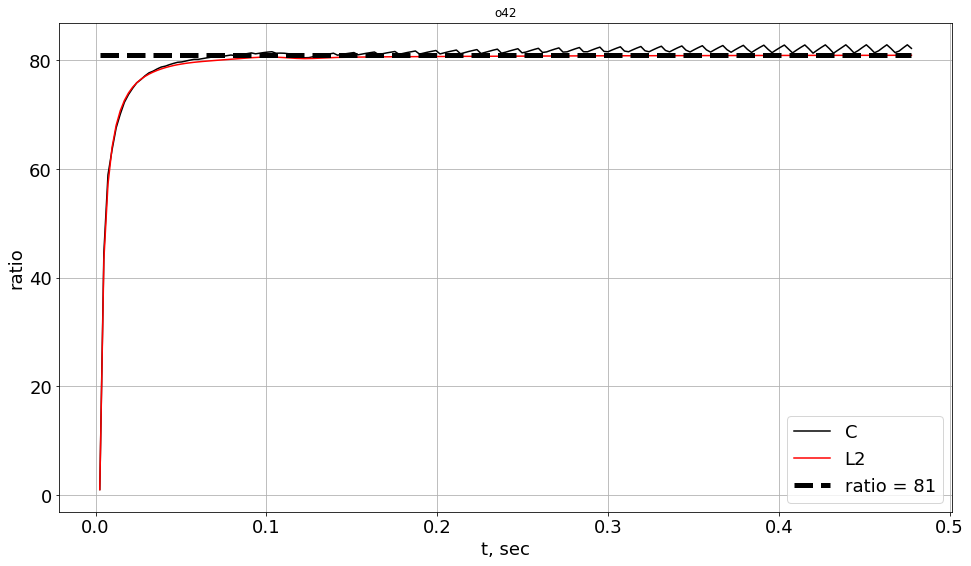

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from celluloid import Camera
import os
from numba import njit

def v0(r, a, b) : 
    if (r > a) and (r < b) : 
        return np.exp((-4*(2*r-(a+b))**2) / ((b-a)**2 - (2*r - (a+b))**2))
    else : 
        return 0
        
def U(x, a, b) : 
    return v0(x, a, b)
    
def analytical(r, t, c, a, b) : 
    return U(c*t-r, a, b)
    
def solvero42(rmin, rmax, T, c, a, b, I, C, k) : 
    h = (rmax - rmin) / I
    r = np.zeros(I+2)
    for i in range(len(r)) : 
        r[i] = rmin + (i - 0.5) * h
    tau = C*h/(c*k)
    rr = lambda i: rmin + (i - 0.5)*h
    
    if (C > 1) : 
        print('C must be <= 1') 
    t = np.array([])
    for i in range(T) : 
        t = np.append(t, tau*i)
    print(len(t))
        
    u = np.zeros((len(t), len(r)))
    
    for i in range(len(r)) : 
        u[0, i] = analytical(r[i], 0, c, a, b)
        u[1, i] = analytical(r[i], tau, c, a, b)
        
    for n in range(1, len(t) - 1) : 
        for i in range(2, len(r) - 2) :
            u[n+1,i] = 2 * u[n, i] - u[n-1, i] + tau**2*c**2*(-5*u[n, i]/2 + 4*(u[n, i-1] + u[n, i+1])/3 - (u[n, i-2]+u[n, i+2])/12)/h**2
        u[n+1, 1] = u[n+1, 2]
        u[n+1, 0] = u[n+1, 1]
        u[n+1, -2] = u[n+1, -3]
        u[n+1, -1] = u[n+1, -2] 
         
    return u, r, t

def solvero62(rmin, rmax, T, c, a, b, I, C, k) : 
    h = (rmax - rmin) / I
    r = np.zeros(I+2)
    for i in range(len(r)) : 
        r[i] = rmin + (i - 0.5) * h
    tau = C*h/(c*k)
    rr = lambda i: rmin + (i - 0.5)*h
    
    if (C > 1) : 
        print('C must be <= 1') 
    t = np.array([])
    for i in range(T) : 
        t = np.append(t, tau*i)
    print(len(t))
        
    u = np.zeros((len(t), len(r)))
    
    for i in range(len(r)) : 
        u[0, i] = analytical(r[i], 0, c, a, b)
        u[1, i] = analytical(r[i], tau, c, a, b)
        
    for n in range(1, len(t) - 1) : 
        for i in range(3, len(r) - 3) :
            u[n+1,i] = 2 * u[n, i] - u[n-1, i] + tau**2*c**2*(-49*u[n, i]/18 + 3*(u[n, i-1] + u[n, i+1])/2 - 3*(u[n, i-2]+u[n, i+2])/20 + (u[n, i-3]+u[n, i+3])/90)/h**2
        u[n+1, 2] = u[n+1, 3]
        u[n+1, 1] = u[n+1, 2]
        u[n+1, 0] = u[n+1, 1]
        u[n+1, -3] = u[n+1, -4]
        u[n+1, -2] = u[n+1, -3]
        u[n+1, -1] = u[n+1, -2] 
         
    return u, r, t

 
    
def getNewU(u,tIndex,rIndex):
    newU = np.zeros((len(tIndex), len(rIndex)))
    for n in range(len(tIndex)):
        for i in range(len(rIndex)):
            newU[n,i] = u[tIndex[n], rIndex[i]]
    return newU

def checkConvergence(un1, tn1, rn1, un2, tn2, rn2, un3, tn3, rn3, I, rmin, rmax, flag) : 
    
    y = np.array([])
    if flag == 0 : 
        tIndex2 = [i for i in range(0,len(tn2),9)]
        tIndex3 = [i for i in range(0,len(tn3),81)]
        a81 = np.zeros(len(tn1[1:])) + 81
        label = 'ratio = 81'
        name = 'o42'
    else :
        tIndex2 = [i for i in range(0,len(tn2),3**3)]
        tIndex3 = [i for i in range(0,len(tn3),3**6)]
        a81 = np.zeros(len(tn1[1:])) + 729
        label = 'ratio = 729'
        name = 'o62'
        
    rIndex2 = [i for i in range(2,len(rn2),3)]
    rIndex3 = [i for i in range(5,len(rn3),9)]
    newu1 = un1[:, 1:-1]
    newu2 = getNewU(un2, tIndex2, rIndex2)
    newu3 = getNewU(un3, tIndex3, rIndex3)
    
    yy = np.array([])
    h = (rmax - rmin) / I
    for i in range(1, len(tn1)) : 
        y = np.append(y, np.max(np.abs(newu1[i] - newu2[i]))/np.max(np.abs(newu2[i] - newu3[i])))
        yy = np.append(yy, np.sqrt(np.sum(h * np.abs(newu1[i] - newu2[i])**2)) / np.sqrt(np.sum(h * np.abs(newu2[i] - newu3[i])**2)))
    
    
    fig = plt.figure(figsize = (16, 9))
    ax = fig.add_subplot(111)
    
    ax.plot(tn1[1:], y, linestyle = '-', marker = 'None', color = 'black', label = 'C')
    ax.plot(tn1[1:], yy, linestyle = '-', marker = 'None', color = 'red', label = 'L2')
    ax.plot(tn1[1:], a81, linestyle = '--', marker = 'None', color = 'black', label = label, linewidth = 5)
    

    xax = ax.xaxis
    xlocs = xax.get_ticklocs()
    xlabels = xax.get_ticklabels()
    xlines = xax.get_ticklines()

    xax.grid(True)

    for label in xlabels :
        label.set_color('black')
        label.set_rotation(0)
        label.set_fontsize(18)
    
    yax = ax.yaxis
    ylocs = yax.get_ticklocs()
    ylabels = yax.get_ticklabels()
    ylines = yax.get_ticklines()
    yax.grid(True)

    for label in ylabels :
        label.set_color('black')
        label.set_rotation(0)
        label.set_fontsize(18)
        
    plt.title(name)
    plt.legend(loc = 'best', fontsize = 18)
    plt.xlabel('t, sec', fontsize = 18)
    plt.ylabel('ratio', fontsize = 18)
        
    os.chdir(os.getcwd() + "\convergence")
    plt.savefig(fname = name + '.jpg')
    os.chdir(os.getcwd().replace("\convergence", "")) 

rmin = 0.1
rmax = 1.9
c = 1.5
a = -0.6
b = -0.1
C = 0.8
T = 200 # Здесь T уже не заданное время, а число шагов, ибо не понятно, как правильно выбирать одинаковые точки
I = 2*T

un1, rn1, tn1 = solvero42(rmin, rmax, T, c, a, b, I, C, 1)
un2, rn2, tn2 = solvero42(rmin, rmax, 9*T, c, a, b, 3*I, C, 3)
un3, rn3, tn3 = solvero42(rmin, rmax, 81*T, c, a, b, 9*I, C, 9)

#un1, rn1, tn1 = solvero62(rmin, rmax, T, c, a, b, I, C, 1)
#un2, rn2, tn2 = solvero62(rmin, rmax, 3**3*T, c, a, b, 3*I, C, 9)
#un3, rn3, tn3 = solvero62(rmin, rmax, 3**6*T, c, a, b, 9*I, C, 81)
    
checkConvergence(un1, tn1, rn1, un2, tn2, rn2, un3, tn3, rn3, I, rmin, rmax, 0)
    
    
    